# **Image Blending using Pyramids**

In this notebook, we will blend two images using `cv2.pyrUp()` and `cv2.pyrDown()`
<img src="https://drive.google.com/uc?id=1xAV-cprI69bBd4ZSOm0_eNUECt1T1aBE" width="700">

---

One application of Pyramids is Image Blending. For example, in image stitching, you will need to stack two images together, but it may not look good due to discontinuities between images. In that case, image blending with Pyramids gives you seamless blending without leaving much data in the images. One classical example of this is the blending of two fruits, Orange and Apple. See the result now itself to understand what I am saying:

<img src="https://drive.google.com/uc?id=1WTmBv0oj3L9OorHEUI7j2IsD54CZLMhA" width="400">

Simply it is done as follows:
1. Load the two images of apple and orange
2. Find the Gaussian Pyramids for apple and orange (in this particular example, number of levels is 6)
3. From Gaussian Pyramids, find their Laplacian Pyramids
4. Now join the left half of apple and right half of orange in each levels of Laplacian Pyramids
5. Finally from this joint image pyramids, reconstruct the original image.

In [1]:
import numpy as np
import cv2 # OpenCV-Python
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!wget -O orange.jpg "https://drive.google.com/u/1/uc?id=1yep8BpQi2iuUqONk5JRRMXjUXFnfNQ8A&export=download"
!wget -O apple.jpg "https://drive.google.com/u/1/uc?id=1KSM-QRS7S4BvEpAp18-U0YmQvGv4Ahi6&export=download"

--2022-05-16 23:52:45--  https://drive.google.com/u/1/uc?id=1yep8BpQi2iuUqONk5JRRMXjUXFnfNQ8A&export=download
Resolving drive.google.com (drive.google.com)... 173.194.216.101, 173.194.216.113, 173.194.216.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1yep8BpQi2iuUqONk5JRRMXjUXFnfNQ8A&export=download [following]
--2022-05-16 23:52:45--  https://drive.google.com/uc?id=1yep8BpQi2iuUqONk5JRRMXjUXFnfNQ8A&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sgfa5jb98g3t74bbs14ivnr576a3vhe4/1652745150000/03995330158540788625/*/1yep8BpQi2iuUqONk5JRRMXjUXFnfNQ8A?e=download [following]
--2022-05-16 23:52:45--  https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

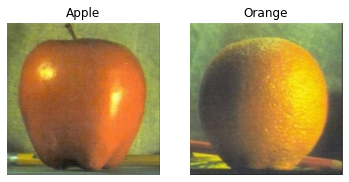

In [3]:
# Load images
A = np.asarray(Image.open('apple.jpg')) # TODO 1. Load apple.jpg Image and convert to numpy array
B = np.asarray(Image.open('orange.jpg')) # TODO 2. Load orange.jpg Image and convert to numpy array 

# TODO 3. Plot Apple.jpg and Orange.jpg Iamges
plt.subplot(1, 2, 1); plt.title('Apple'); plt.axis('off')
plt.imshow(A)
plt.subplot(1, 2, 2); plt.title('Orange'); plt.axis('off')
plt.imshow(B)
plt.show()

## **1. Generate Gaussian pyramids**

`dst = cv2.pyrDown(src)`

- `input`: input image
- `output`: blur & downsampled image


Blurs an image and downsamples it.

By default, size of the output image is computed as `Size((src.cols+1)/2, (src.rows+1)/2)`, but in any case, the following conditions should be satisfied:
$|𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚠𝚒𝚍𝚝𝚑∗2−src.cols|≤2 \\|𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚑𝚎𝚒𝚐𝚑𝚝∗2−src.rows|≤2$

The function performs the downsampling step of the Gaussian pyramid construction. First, it convolves the source image with the gaussian kernel, Then, it downsamples the image by rejecting even rows and columns.

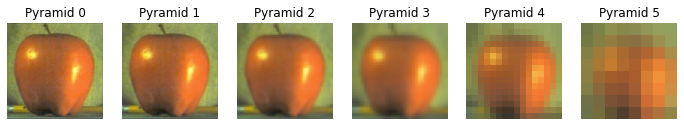

In [4]:
G = A.copy()
gpA = [G]
# generate Gaussian pyramid for A
for i in range(5): # total stage 5
    # TODO 1. apply pyrDown function and append results to the gpA variable
    G = cv2.pyrDown(G)
    gpA.append(G)
    
# TODO 2. plot images in gpA
plt.figure(figsize=(12, 12))
for i, gp in enumerate(gpA):
    plt.subplot(1, len(gpA), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(gp)
plt.show()

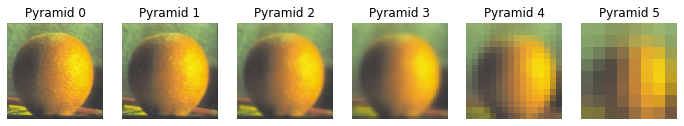

In [5]:
# TODO 1. generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(5):
    G = cv2.pyrDown(G)
    gpB.append(G)
    
# TODO 2. plot pyramids
plt.figure(figsize=(12, 12))
for i, gp in enumerate(gpB):
    plt.subplot(1, len(gpB), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(gp)
plt.show()

## **2. Generate Laplacian pyramids**

`dst = cv2.pyrUp(src)`

- `input`: input image
- `output`: output image (same shape & datatype with src)


Upsamples an image and then blurs it.

By default, size of the output image is computed as Size(src.cols\*2, (src.rows\*2), but in any case, the following conditions should be satisfied:

$|𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚠𝚒𝚍𝚝𝚑−src.cols∗2|≤(𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚠𝚒𝚍𝚝𝚑 \% 2)\\|𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚑𝚎𝚒𝚐𝚑𝚝−src.rows∗2|≤(𝚍𝚜𝚝𝚜𝚒𝚣𝚎.𝚑𝚎𝚒𝚐𝚑𝚝 \% 2)$

The function performs the upsampling step of the Gaussian pyramid construction, though it can actually be used to construct the Laplacian pyramid. 

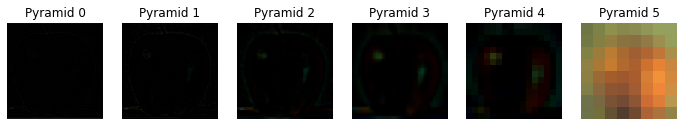

In [6]:
lpA = [gpA[5]]
for i in range(5,0,-1):
    # TODO 1. apply pyrUp function for upsampling
    dstsize = (gpA[i-1].shape[1], gpA[i-1].shape[0])
    GE = cv2.pyrUp(gpA[i], dstsize=dstsize)
    # TODO 2. get laplacian image by subtracting next(higher) level of gaussian image and upsampled iamge
    L = cv2.subtract(gpA[i-1],GE)
    # TODO 3. put result to lpA
    lpA.append(L)
    
lpA.reverse()
# TODO 4. plot laplacian pyramid
plt.figure(figsize=(12, 12))
for i, lp in enumerate(lpA):
    plt.subplot(1, len(lpA), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(lp)
plt.show()

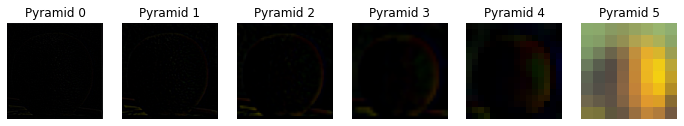

In [7]:
# TODO 1. generate Laplacian pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv2.pyrUp(gpB[i], dstsize=gpB[i-1].shape[:2])
    L = cv2.subtract(gpB[i-1],GE)
    #L = gpB[i-1] - GE
    lpB.append(L)
    
lpB.reverse()
# TODO 2. plot pyramid 0 ~ 5
plt.figure(figsize=(12, 12))
for i, lp in enumerate(lpB):
    plt.subplot(1, len(lpB), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(lp)
plt.show()

## **3. Add left and right halves of images in each level**

`np.hstack((A, B))`: concat A and B with dimension=1 (horizontal concat)

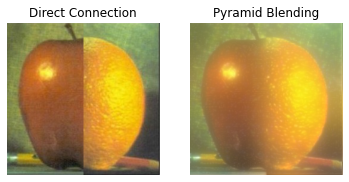

In [8]:
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    # TODO 1. concat left and right halves of laplacian image in each level
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    # TODO 2. put result to the LS variable
    LS.append(ls)
    
# reconstruct image
# TODO 1. select last level of Gaussian pyramid image
ls_ = LS[5]
for i in range(5, 0, -1):
    # TODO 2. apply pyrUp, add laplacian image
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i-1])
    
# image with direct connecting each half
rows, cols, dpt = A.shape
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))
    
plt.subplot(1, 2, 1); plt.title('Direct Connection'); plt.axis('off')
plt.imshow(real)
plt.subplot(1, 2, 2); plt.title('Pyramid Blending'); plt.axis('off')
plt.imshow(ls_)
plt.show()

# **Practice: Image Blending with a mask**

Let's make "Hand of Eye of Flame"!

<img src="https://drive.google.com/uc?id=1agt3TYzKe9bHozTUtp2w02Zg2w3DxNbJ" width="400">


In [9]:
!wget -O hand.jpg "https://drive.google.com/u/1/uc?id=1L3Ev5-ggzHqFnIJ9sbTrYUOsm0wBOKPy&export=download"
!wget -O eye-template.jpg "https://drive.google.com/u/1/uc?id=1CSwcgHGP2Si90Qyt2IDDdfq9Hj7rsRx8&export=download"
!wget -O eye-mask.jpg "https://drive.google.com/u/1/uc?id=1U9G0O1jeSRSmZz7W9hXU23nWGdZUuDoZ&export=download"

--2022-05-16 23:52:49--  https://drive.google.com/u/1/uc?id=1L3Ev5-ggzHqFnIJ9sbTrYUOsm0wBOKPy&export=download
Resolving drive.google.com (drive.google.com)... 173.194.215.113, 173.194.215.102, 173.194.215.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1L3Ev5-ggzHqFnIJ9sbTrYUOsm0wBOKPy&export=download [following]
--2022-05-16 23:52:49--  https://drive.google.com/uc?id=1L3Ev5-ggzHqFnIJ9sbTrYUOsm0wBOKPy&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/isu4i2smhvr879n4gfp6at540klp2t09/1652745150000/03995330158540788625/*/1L3Ev5-ggzHqFnIJ9sbTrYUOsm0wBOKPy?e=download [following]
--2022-05-16 23:52:49--  https://doc-0s-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

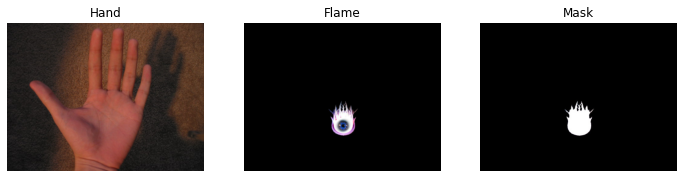

In [10]:
# Load images
# TODO 1. Load hand.jpg image and convert to numpy array
A = np.asarray(Image.open('hand.jpg')) 
# TODO 2. Load eye-template.jpg image and convert to numpy array
B = np.asarray(Image.open('eye-template.jpg')) 
# TODO 3. Load eye-mask.jpg image and convert to numpy array
M = np.asarray(Image.open('eye-mask.jpg')) 

# TODO 4. Plot Hand, eye-template, eye-mask images
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1); plt.title('Hand'); plt.axis('off')
plt.imshow(A)
plt.subplot(1, 3, 2); plt.title('Flame'); plt.axis('off')
plt.imshow(B)
plt.subplot(1, 3, 3); plt.title('Mask'); plt.axis('off')
plt.imshow(M, cmap='gray')
plt.show()

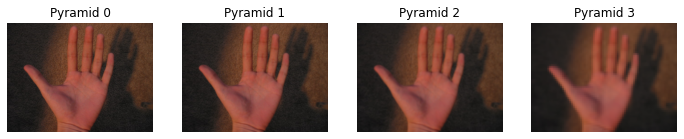

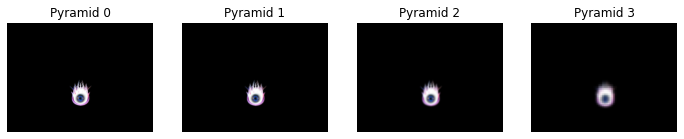

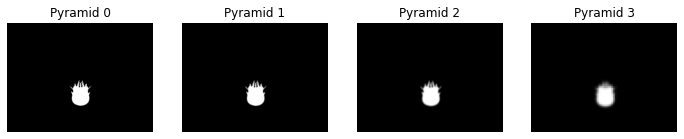

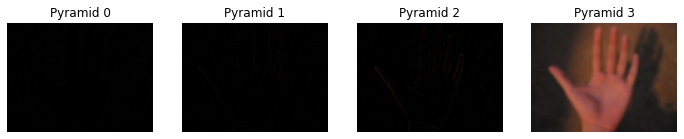

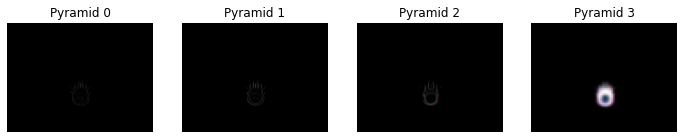

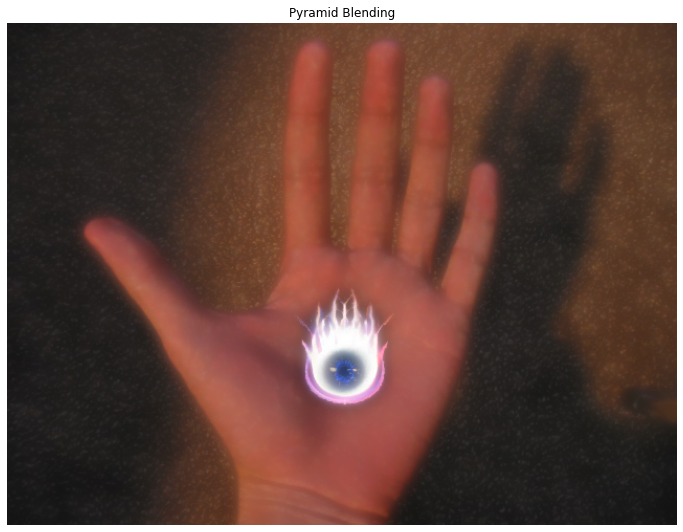

In [11]:
stage = 3
# TODO 1. Gaussian pyramids of A
G = A.copy()
gpA = [G]
for i in range(stage):
    G = cv2.pyrDown(G)
    gpA.append(G)
    
# TODO 2. Plot Gaussian pyramids of A 
plt.figure(figsize=(12, 12))
for i, gp in enumerate(gpA):
    plt.subplot(1, len(gpA), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(gp)
    
# TODO 3. Gaussian pyramids of B
G = B.copy()
gpB = [G]
for i in range(stage):
    G = cv2.pyrDown(G)
    gpB.append(G)
    
# TODO 4. Plot Gaussian pyramids of B
plt.figure(figsize=(12, 12))
for i, gp in enumerate(gpB):
    plt.subplot(1, len(gpB), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(gp)
    
# TODO 5. Gaussian pyramids of M
G = M.copy()
gpM = [G]
for i in range(stage):
    G = cv2.pyrDown(G)
    gpM.append(G)  
    
# TODO 6. Plot Gaussian pyramids of M
plt.figure(figsize=(12, 12))
for i, gp in enumerate(gpM):
    plt.subplot(1, len(gpM), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(gp)
    
# TODO 7. Laplacian pyramids of A
lpA = [gpA[stage]]
for i in range(stage,0,-1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)
lpA.reverse()

# TODO 8. plot Laplacian pyramids of A
plt.figure(figsize=(12, 12))
for i, lp in enumerate(lpA):
    plt.subplot(1, len(lpA), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(lp)
    
# TODO 9. Laplacian pyramids of B
lpB = [gpB[stage]]
for i in range(stage,0,-1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1],GE)
    lpB.append(L)
lpB.reverse()
    
# TODO 10. Plot Laplacian pyramids of B
plt.figure(figsize=(12, 12))
for i, lp in enumerate(lpB):
    plt.subplot(1, len(lpB), i+1); plt.title('Pyramid %d' % i); plt.axis('off');
    plt.imshow(lp)

# TODO 11. Merge Laplacian pyramids of A and B with mask in each level   
LS = []
for (la,lb, gm) in zip(lpA,lpB, gpM):
    masked_la = (la.astype('float') * (255.0 - gm.astype('float')) / 255.0).astype('uint8')
    masked_lb = (lb.astype('float') * gm.astype('float') / 255.0).astype('uint8')
    ls = masked_la + masked_lb
    LS.append(ls)
    
# TODO 12. reconstruct images
ls_ = LS[stage]
for i in range(stage, 0, -1):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i - 1])

plt.figure(figsize=(12, 12))
plt.subplot(1, 1, 1); plt.title('Pyramid Blending'); plt.axis('off')
plt.imshow(ls_)
plt.show()

### Reference

- [Image Pyramids - OpenCV documentation](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html#py-pyramids)
- [Hand of Eye of Flame](http://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/f06/pub/www/projects/proj3/fkg/)